In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
class linear_regression:
    def _mserror(self, w, X, y_real):
        w0, w=w[0], w[1:] 
        w=w[np.newaxis, :]
        #рассчёт среднеквадратичной ошибки
        y = X.dot(w.T)+w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, w, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        w0, w=w[0], w[1:] 
        w=w[np.newaxis, :]
        delta=(X.dot(w.T)+w0-y_real)
        return np.concatenate([[np.sum(2*delta)/y_real.shape[0]], (2*delta.T.dot(X)/y_real.shape[0]).flatten()])
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        w=np.zeros(X.shape[1]+1)
        w=minimize(self._mserror, w, args=(X, Y), jac=self._mserror_grad).x
        self.w0, self.w=w[0], w[1:]
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(np.concatenate([[self.w0], self.w]), X, Y)

class polynomial_regression(linear_regression):
    def __init__(self, max_power):
        self.max_power=max_power
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y)

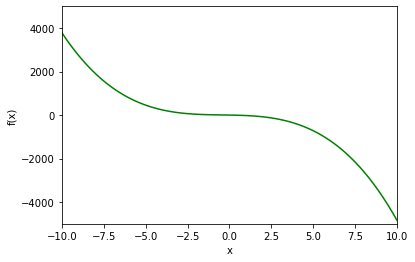

In [4]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')

In [34]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 10)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 10)

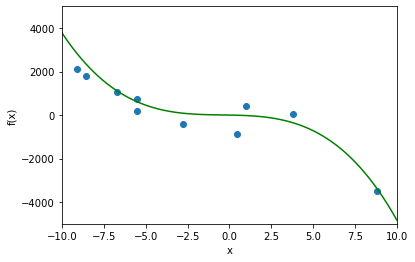

In [35]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

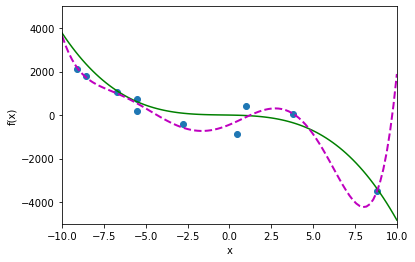

In [36]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Sklearn
model2 = polynomial_regression(6)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

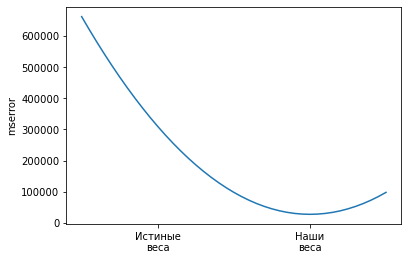

In [22]:
#Истиные коэффициенты используемые для генерации данных
w_true=np.array([[- 13.2,  - 5.3,  - 4.17, 0, 0, 0]])
w0_true=0.6

x=polynomial_regression.generate_features(x_data, 6)
y=f_data[:, np.newaxis]
n_samples=len(f_data)

x_dots=np.arange(-0.5, 1.55, 0.05)
def _mserror(w, w0):
    diff=x.dot(w.T)+w0-y
    return np.sum(diff**2)/n_samples

mserror_values=np.array([_mserror(w_true+(model2.w-w_true)*i, w0_true+(model2.w0-w0_true)*i) 
                         for i in x_dots])
#Актуальные данные
plt.ylabel('mserror')
plt.xticks([0, 1], ['Истиные\nвеса', 'Наши\nвеса'])
plt.plot(x_dots, mserror_values)

In [52]:
def generate_subset_models(x, y, portion, N):
    indexes=np.arange(x.shape[0])
    np.random.shuffle(indexes)
    k=int(x.shape[0]*portion)
    res=[]
    for i in range(N):
        mod=polynomial_regression(6)
        mod.fit(x[indexes[:k]], y[indexes[:k]])
        res.append(mod)
        np.random.shuffle(indexes)
    return res
def predict(models, x):
    res=np.concatenate([mod.predict(x)[:, np.newaxis] for mod in models], axis=1)
    return np.apply_along_axis(np.median, 1, res)

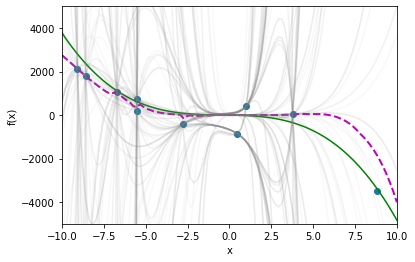

In [53]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Bagging модель
models = generate_subset_models(x_data, f_data, 0.3, 150)
plt.plot(dots, predict(models, dots), 'm--', linewidth=2)

#Отдельные модели из ансамбля
for mod in models:
    plt.plot(dots, mod.predict(dots), alpha=0.05, color='grey')